### Import Modules and Libraries

In [13]:
import time
import joblib

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

### Dataset Processing

In [14]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Custom collate function to pad sequences
def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    lengths = torch.tensor([len(seq) for seq in sequences])
    labels_padded = pad_sequence(labels, batch_first=True)
    return sequences_padded, labels_padded, lengths

In [15]:
# List all CSV files in the dataset folder
dataset_folder = '../dataset'
csv_files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]

In [16]:
# Load all CSV files into a single pandas DataFrame
dataset = []

for episode_num, file in enumerate(csv_files):
    episode = pd.read_csv(os.path.join(dataset_folder, file))
    episode['episode'] = episode_num
    dataset.append(episode)

dataset = pd.concat(dataset)

# One-hot encode the failed_motor column
one_hot_failed_motor = pd.get_dummies(dataset['failed_motor'], prefix='motor')
dataset = pd.concat([dataset, one_hot_failed_motor], axis=1)

# Handle missing values (if any)
dataset = dataset.dropna()

# Normalize the data
scaler = StandardScaler()
features = dataset.drop(columns=['timestamp', 'motor_failure_flag', 'failed_motor', 'motor_0', 'motor_1', 'motor_2', 'motor_3', 'motor_4', 'episode'])
scaled_features = scaler.fit_transform(features)
joblib.dump(scaler, '../models/scaler.pkl')

# Add the normalized features back to the dataframe
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['motor_failure_flag'] = dataset['motor_failure_flag'].values
scaled_df['episode'] = dataset['episode'].values
scaled_df[['motor_1', 'motor_2', 'motor_3', 'motor_4']] = dataset[['motor_1', 'motor_2', 'motor_3', 'motor_4']].values

# Prepare sequences for each episode
sequences = []
labels = []

for episode_num in scaled_df['episode'].unique():
    episode_data = scaled_df[scaled_df['episode'] == episode_num]
    X = episode_data.drop(columns=['motor_failure_flag', 'motor_1', 'motor_2', 'motor_3', 'motor_4', 'episode']).values
    y = episode_data[['motor_failure_flag', 'motor_1', 'motor_2', 'motor_3', 'motor_4']].values.astype(np.float32)
    sequences.append(torch.tensor(X, dtype=torch.float32))
    labels.append(torch.tensor(y, dtype=torch.float32))

# Split the data into training and validation sets
train_sequences, val_sequences, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = TimeSeriesDataset(train_sequences, train_labels)
val_dataset = TimeSeriesDataset(val_sequences, val_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Display the shapes of the tensors
print(f"Number of training sequences: {len(train_dataset)}")
print(f"Shape of first training sequence: {train_dataset[0][0].shape}")
print(f"Shape of first training label: {train_dataset[0][1].shape}")

print(f"Number of validation sequences: {len(val_dataset)}")
print(f"Shape of first validation sequence: {val_dataset[0][0].shape}")
print(f"Shape of first validation label: {val_dataset[0][1].shape}")

Number of training sequences: 80
Shape of first training sequence: torch.Size([55, 16])
Shape of first training label: torch.Size([55, 5])
Number of validation sequences: 21
Shape of first validation sequence: torch.Size([38, 16])
Shape of first validation label: torch.Size([38, 5])


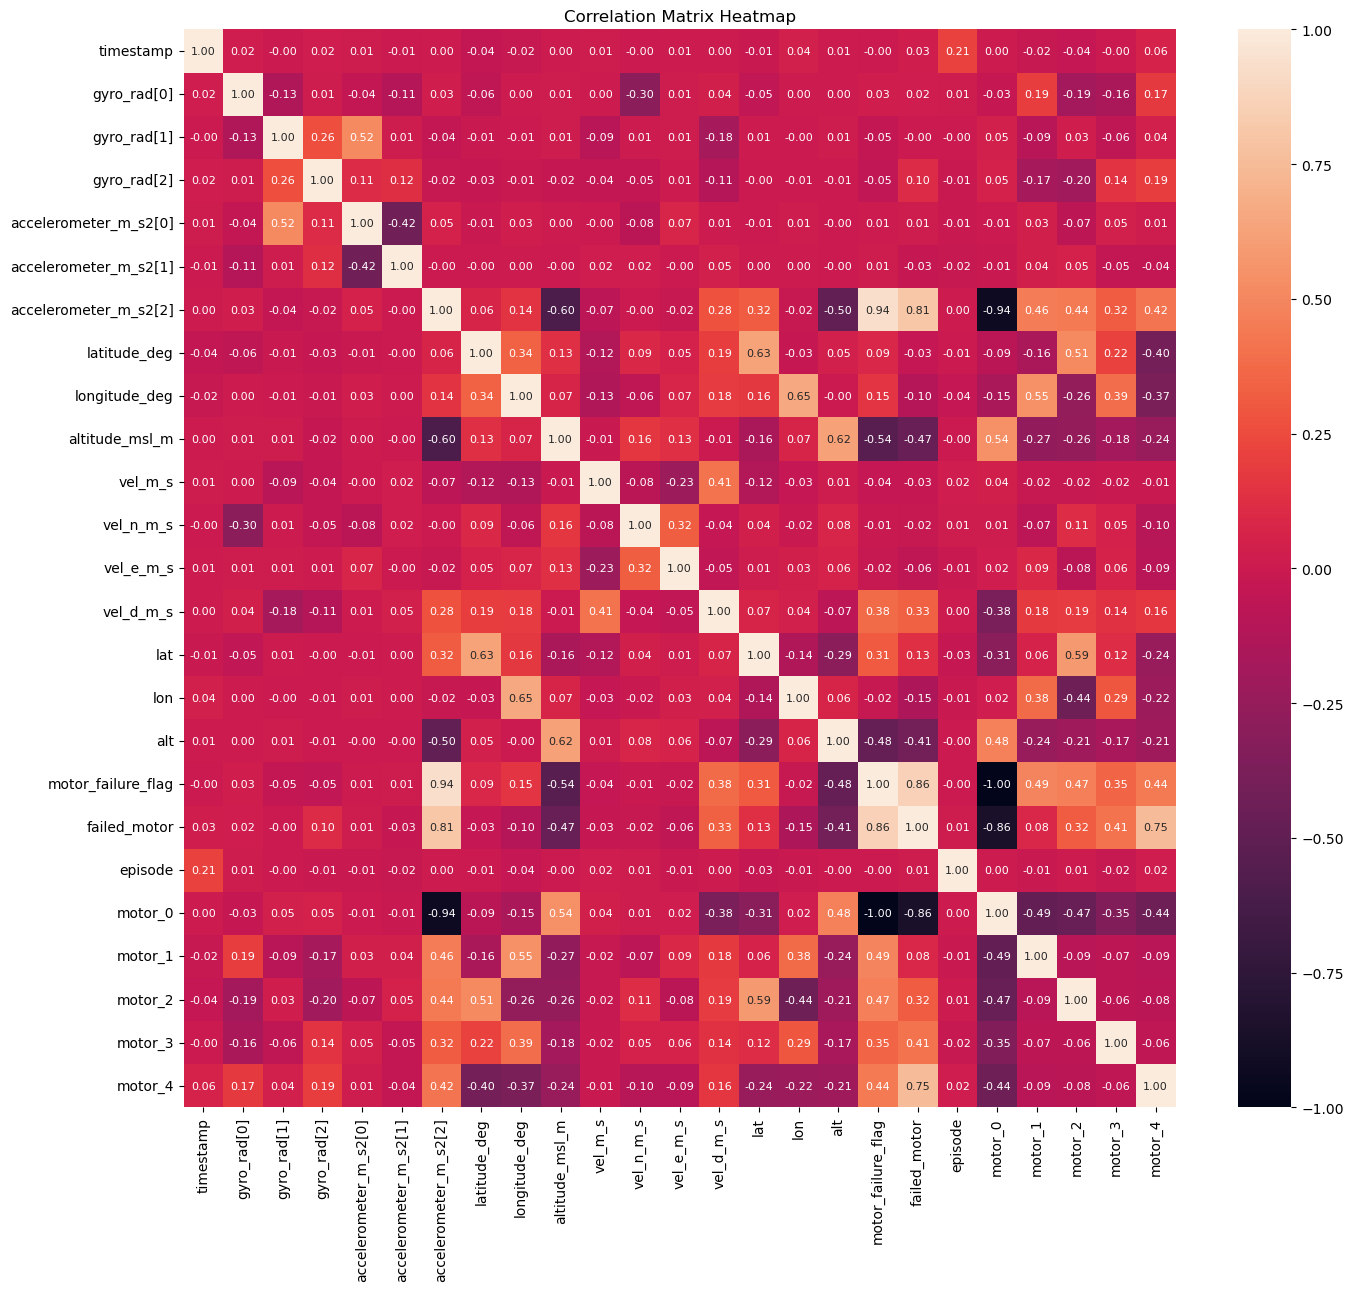

In [17]:
# Calculate the correlation matrix
correlation_matrix = dataset.corr()

# Optionally, you can visualize the correlation matrix using a heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix Heatmap')
plt.show()

### Drone Failure Detection Model

In [18]:
class MotorFailureDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3, output_size=1, dropout_prob=0.3):
        super(MotorFailureDetectionModel, self).__init__()
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM layers
        packed_output, _ = self.lstm(packed_input)
        
        # Unpack the sequence
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Fully connected layer with dropout and activation
        out = self.fc(lstm_out)
        out = self.sigmoid(out)
        
        return out

    def train_model(self, train_loader, num_epochs=10, learning_rate=0.001, device='cpu'):
        # Set model to training mode
        self.train()
        
        # Loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        # Move model to device
        self.to(device)
        
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            start_time = time.time()
            for batch_idx, (data, target, lengths) in enumerate(train_loader):
                # Move data and target to device
                data, target, lengths = data.to(device), target.to(device), lengths.to(device)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                output = self(data, lengths)
                
                # Calculate loss
                # Mask the padded values in the target
                mask = torch.arange(target.size(1)).expand(len(lengths), target.size(1)).to(device) < lengths.unsqueeze(1)
                masked_output = output[mask]
                masked_target = target[mask]
                loss = criterion(masked_output, masked_target)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Accumulate loss for the epoch
                epoch_loss += loss.item()
                
                # Print progress every 100 batches
                if batch_idx % 5 == 0 and (((epoch+1) % 10 == 0) or (epoch == 0)):
                    print(f'Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(train_loader)}] | Loss: {loss.item():.4f}\n')

            # Print average loss for the epoch
            if ((epoch+1) % 10 == 0) or (epoch == 0):
                print(f'{"-"*70}\n')
                print(f'Epoch [{epoch+1}/{num_epochs}] | Average Loss: {epoch_loss/len(train_loader):.4f} | Time: {time.time()-start_time:.2f}s')
                print(f'\n{"-"*70}\n')

    def save_model(self, file_name):
        # Save the model's state dict
        directory = "../models"
        file_path = os.path.join(directory, file_name)
        os.makedirs(directory, exist_ok=True)
        torch.save(self.state_dict(), file_path)
        print(f'Model saved to {file_path}')
    
    def load_model(self, file_path, device='cpu'):
        # Load the model's state dict
        self.load_state_dict(torch.load(file_path, map_location=device))
        self.to(device)
        print(f'Model loaded from {file_path}')

In [19]:
# Model initialization
input_size = 16   # 16 features: gyro_rad[0], gyro_rad[1], gyro_rad[2], accelerometer_m_s2[0], accelerometer_m_s2[1], accelerometer_m_s2[2], latitude_deg, longitude_deg, altitude_msl_m, vel_m_s, vel_n_m_s, vel_e_m_s, vel_d_m_s, lat, lon, alt
hidden_size = 64
num_layers = 3
output_size = 5   # 5 outputs: motor_failure_flag, motor_1, motor_2, motor_3, motor_4
dropout_prob = 0.3

model = MotorFailureDetectionModel(input_size, hidden_size, num_layers, output_size, dropout_prob)
print(model)

MotorFailureDetectionModel(
  (lstm): LSTM(16, 64, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


### Training the Model

In [20]:
# Training
num_epochs = 20
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.train_model(train_loader, num_epochs=num_epochs, learning_rate=learning_rate, device=device)

Epoch [1/20] | Batch [1/20] | Loss: 0.6670

Epoch [1/20] | Batch [6/20] | Loss: 0.6420

Epoch [1/20] | Batch [11/20] | Loss: 0.6030

Epoch [1/20] | Batch [16/20] | Loss: 0.5520

----------------------------------------------------------------------

Epoch [1/20] | Average Loss: 0.5911 | Time: 1.36s

----------------------------------------------------------------------

Epoch [10/20] | Batch [1/20] | Loss: 0.1229

Epoch [10/20] | Batch [6/20] | Loss: 0.1584

Epoch [10/20] | Batch [11/20] | Loss: 0.1497

Epoch [10/20] | Batch [16/20] | Loss: 0.1424

----------------------------------------------------------------------

Epoch [10/20] | Average Loss: 0.1398 | Time: 1.01s

----------------------------------------------------------------------

Epoch [20/20] | Batch [1/20] | Loss: 0.0624

Epoch [20/20] | Batch [6/20] | Loss: 0.0649

Epoch [20/20] | Batch [11/20] | Loss: 0.0675

Epoch [20/20] | Batch [16/20] | Loss: 0.0440

-------------------------------------------------------------------

### Evaluate the Model

In [21]:
def evaluate_model(model, data_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.BCELoss()
    total_loss = 0.0

    all_targets = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target, lengths in data_loader:
            data, target, lengths = data.to(device), target.to(device), lengths.to(device)
            
            # Forward pass
            output = model(data, lengths)
            
            # Calculate loss
            mask = torch.arange(target.size(1)).expand(len(lengths), target.size(1)).to(device) < lengths.unsqueeze(1)
            masked_output = output[mask]
            masked_target = target[mask]
            loss = criterion(masked_output, masked_target)
            total_loss += loss.item()
            
            # Store all targets and predictions for metric calculation
            all_targets.append(masked_target.cpu().numpy())
            all_predictions.append((masked_output > 0.5).float().cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    
    # Concatenate all targets and predictions
    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    
    # Calculate metrics for each output
    metrics = {}
    for i in range(5):
        accuracy = (all_predictions[:, i] == all_targets[:, i]).mean()
        precision = precision_score(all_targets[:, i], all_predictions[:, i])
        recall = recall_score(all_targets[:, i], all_predictions[:, i])
        f1 = f1_score(all_targets[:, i], all_predictions[:, i])
        metrics[f'output_{i+1}'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    return avg_loss, metrics

In [22]:
# Evaluate the model
val_loss, val_metrics = evaluate_model(model, val_loader, device=device)

# Print the evaluation results
print(f'Validation Loss: {val_loss:.4f}')
for output, metric in val_metrics.items():
    print(f'{output} - Accuracy: {metric["accuracy"]:.4f}, Precision: {metric["precision"]:.4f}, Recall: {metric["recall"]:.4f}, F1 Score: {metric["f1"]:.4f}')

Validation Loss: 0.0531
output_1 - Accuracy: 0.9953, Precision: 0.9920, Recall: 0.9920, F1 Score: 0.9920
output_2 - Accuracy: 0.9930, Precision: 1.0000, Recall: 0.9310, F1 Score: 0.9643
output_3 - Accuracy: 0.9977, Precision: 1.0000, Recall: 0.9677, F1 Score: 0.9836
output_4 - Accuracy: 0.9953, Precision: 1.0000, Recall: 0.8462, F1 Score: 0.9167
output_5 - Accuracy: 0.9848, Precision: 1.0000, Recall: 0.8289, F1 Score: 0.9065


### Save the Model

In [23]:
# Save the model
model_name = 'Failure-Detection-0.pth'
model.save_model(model_name)

Model saved to ../models/Failure-Detection-0.pth


### Load the Model

In [24]:
# Initialize the hyperparameters
input_size = 16
hidden_size = 64
num_layers = 3
output_size = 5
dropout_prob = 0.3

# Load the model
model_name = 'Failure-Detection-0.pth'
model = MotorFailureDetectionModel(input_size, hidden_size, num_layers, output_size, dropout_prob)
model.load_model(os.path.join('../models', model_name), device=device)

Model loaded from ../models/Failure-Detection-0.pth


/tmp/ipykernel_1138/3737932086.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(file_path, map_location=device))
